## Predicting total energies and formation enthalpies of metal-nonmetal compounds by linear regression 

Here, we want to study the accuracy and time used to predict variable dataset sizes using the featurizations and algorithms used in [Deml et al paper](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.93.085142)

Referred to `matminer_examples/notebooks/machine-learning/predicting-formation-enthalpy-from-composition.ipynb `

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import pymatgen as pmg
import matplotlib.pyplot as plt

from matminer.utils.conversions import str_to_composition, composition_to_oxidcomposition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf

from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lars, LarsCV, LassoLars, lars_path
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from matplotlib.colors import LogNorm

from pymatgen import MPRester

### Loading pickle file

In [2]:
data = pd.read_pickle('./deml_featurized_data.pkl')

### Linear Model: Stepwise Linear Regression 

Remove outliers

In [3]:
original_count = len(data)
data = data[np.logical_and(data['delta_e'] >= -20, data['delta_e'] <= 5)].reset_index(drop=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 0/2501 entries


Fill NaN with zero values

In [4]:
data.fillna(value=0, inplace=True)
data.isnull().any().any()

False

Storing formation enthalpy data for later use

In [5]:
unshuffled_delta_e = data['delta_e']
unshuffled_x = data.drop(['oxidation_states', 'total_energy', 'delta_e', 'composition', 'composition_obj'], 1)

Shuffling data and specifying data to be learnt

In [6]:
data = shuffle(data)

In [7]:
x = data.drop(['oxidation_states', 'total_energy', 'delta_e', 'composition', 'composition_obj'], 1)
y = data['total_energy']

Each dataset is randomly divided into three groups: 
- 70% for training the model
- 15% for preliminary assessment (validation) of model's predictive ability
- 15% for independent assessment (testing) of model's predictive ability

In [8]:
n = data.shape[0]
x_train, x_val, x_test = x[:int(n*0.7)], x[int(n*0.7):int(n*0.85)], x[int(n*0.85):]
y_train, y_val, y_test = y[:int(n*0.7)], y[int(n*0.7):int(n*0.85)], y[int(n*0.85):]

### Part 3: Quantifying performance of LARS model with different number of candidate descriptors used

Implementation of stepwise linear regression where terms (candidate descriptors) from a linear model are sequentially added or removed according to their effective significance probabilities. In the paper, this approach was implemented in [JMP](https://www.jmp.com/en_us/software/predictive-analytics-software.html). Here, we use recursive feature elimination to assign weights to features and remove features with low weightage.




10-fold cross validation was used within the training set to quantify performance of model

In [9]:
kfold = KFold(10, shuffle=True)

Number of terms (candidate descriptors) to be used

In [53]:
# num_features = range(10, data.shape[1], 10)
alpha = range(-9, 1, 1)
num_features = range(5, 20)

Initializing mean absolute error, mean squared error and R2 score

In [54]:
score_train = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_val = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_test = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}

Training the Least Angle Regression (LARS) model with variable number of features used and quantifying the performance. 

In [55]:
for i in num_features:
    selector = Lars(n_nonzero_coefs=i, eps=1e-6)
    selector = selector.fit(x_train, y_train)
    cv_train = cross_val_predict(selector, x_train, y_train, cv=kfold) 
    cv_val = cross_val_predict(selector, x_val, y_val, cv=kfold)
    cv_test = cross_val_predict(selector, x_test, y_test, cv=kfold)
    for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
        score_train[scorer].append(getattr(metrics,scorer)(y_train, cv_train))
        score_val[scorer].append(getattr(metrics,scorer)(y_val, cv_val))
        score_test[scorer].append(getattr(metrics,scorer)(y_test, cv_test))

Plot the model performance when number of terms (candidate descriptors) is changed.

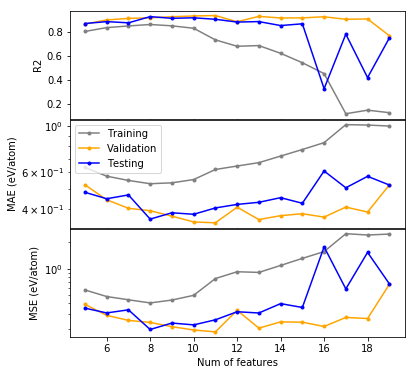

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax3.set_xlabel("Num of features")
ax1.set_ylabel("R2")
ax2.set_ylabel("MAE (eV/atom)")
ax3.set_ylabel("MSE (eV/atom)")

ax1.plot(num_features, score_train['r2_score'], c='grey', marker='.', label='Training')
ax1.plot(num_features, score_val['r2_score'], c='orange', marker='.', label='Validation')
ax1.plot(num_features, score_test['r2_score'], c='blue', marker='.', label='Testing')

ax2.semilogy(num_features, score_train['mean_absolute_error'], c='grey', marker='.', label='Training')
ax2.semilogy(num_features, score_val['mean_absolute_error'], c='orange', marker='.', label='Validation')
ax2.semilogy(num_features, score_test['mean_absolute_error'], c='blue', marker='.', label='Testing')

ax3.semilogy(num_features, score_train['mean_squared_error'], c='grey', marker='.', label='Training')
ax3.semilogy(num_features, score_val['mean_squared_error'], c='orange', marker='.', label='Validation')
ax3.semilogy(num_features, score_test['mean_squared_error'], c='blue', marker='.', label='Testing')

ax2.legend()

fig.set_size_inches(6, 6)
fig.subplots_adjust(hspace=0.01)

Train the model again, but this time using LassoLars model

In [14]:
score_train = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_val = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_test = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}

In [15]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in alpha:
        selector = LassoLars(alpha=10**i)
        selector = selector.fit(x_train, y_train)
        cv_train = cross_val_predict(selector, x_train, y_train, cv=kfold) 
        cv_val = cross_val_predict(selector, x_val, y_val, cv=kfold)
        cv_test = cross_val_predict(selector, x_test, y_test, cv=kfold)
        for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
            score_train[scorer].append(getattr(metrics,scorer)(y_train, cv_train))
            score_val[scorer].append(getattr(metrics,scorer)(y_val, cv_val))
            score_test[scorer].append(getattr(metrics,scorer)(y_test, cv_test))

Text(0,0.5,'mean_absolute_error (eV/atom)')

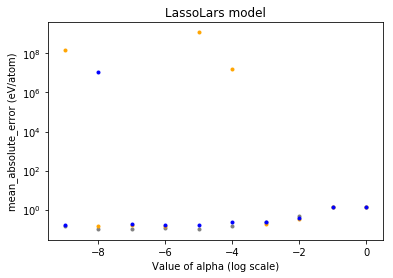

In [16]:
plt.title("LassoLars model")
metric = "mean_absolute_error"
plt.scatter(alpha, score_train[metric], c='grey', marker='.', label='Training')
plt.scatter(alpha, score_val[metric], c='orange', marker='.', label='Validation')
plt.scatter(alpha, score_test[metric], c='blue', marker='.', label='Testing')
plt.yscale('log')

plt.xlabel("Value of alpha (log scale)")
plt.ylabel("%s (eV/atom)" %metric)

_Best_: Using 10 terms. (INTRIGUING)

Prediction is way better using `energy_per_atom` instead of `energy`.

### Choose to use between Lars or LassoLars model for total energy prediction. 

In [60]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    selector_lars = Lars(n_nonzero_coefs=8)
    selector_lassolars = LassoLars(alpha=1E-3)
    selector_lars = selector_lars.fit(x_train, y_train)
    selector_lassolars = selector_lassolars.fit(x_train, y_train)
    for i in selector.active_:
        print (data.columns[i])

mean EN difference
mean heat_cap frac p valence electrons
mean mus_fere avg anion electron affinity
mean GGAU_Etot avg anion electron affinity
std_dev heat_fusion
mean boiling_point frac d valence electrons
mean electric_pol avg p valence electrons
mean heat_cap frac d valence electrons
mean electric_pol
mean first_ioniz frac s valence electrons
mean GGAU_Etot mean sat_magn of cations
mean mus_fere transition metal fraction
sqrt avg p valence electrons
transition metal fraction avg anion electron affinity
mean mus_fere mean EN difference
mean FERE correction num_atoms


In [61]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_train_lars = cross_val_predict(selector_lars, x_train, y_train, cv=kfold) 
    cv_val_lars = cross_val_predict(selector_lars, x_val, y_val, cv=kfold)
    cv_test_lars = cross_val_predict(selector_lars, x_test, y_test, cv=kfold)
    cv_train_lassolars = cross_val_predict(selector_lassolars, x_train, y_train, cv=kfold) 
    cv_val_lassolars = cross_val_predict(selector_lassolars, x_val, y_val, cv=kfold)
    cv_test_lassolars = cross_val_predict(selector_lassolars, x_test, y_test, cv=kfold)

Plot the predictions

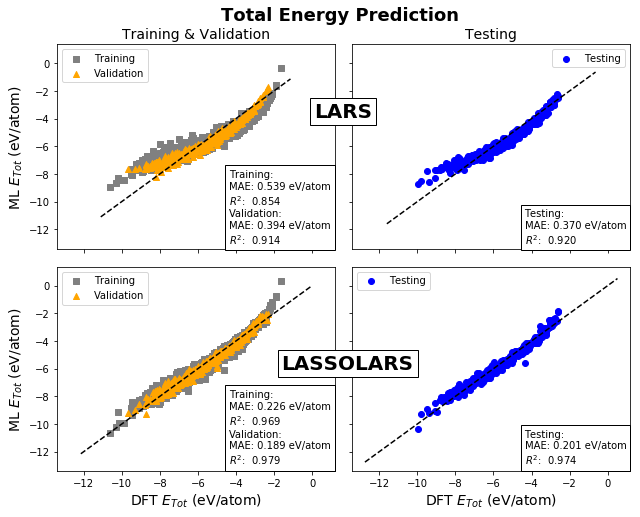

In [62]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

fig.suptitle('Total Energy Prediction', fontsize=18, x=0.53, y=1.02, weight='bold')

# LARS model
# Training and Validation plot
mae_train = metrics.mean_absolute_error(y_train, cv_train_lars)
r2_train = metrics.r2_score(y_train, cv_train_lars)
mae_val = metrics.mean_absolute_error(y_val, cv_val_lars)
r2_val = metrics.r2_score(y_val, cv_val_lars)
ax1.text(0.62, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax1.scatter(y_train, cv_train_lars, c='grey', marker='s', label='Training')
ax1.scatter(y_val, cv_val_lars, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax1.legend()
ax1.set_title('Training & Validation', fontsize=14)
ax1.set_ylabel('ML $E_{Tot}$ (eV/atom)', fontsize=14)

# Testing plot
mae_test = metrics.mean_absolute_error(y_test, cv_test_lars)
r2_test = metrics.r2_score(y_test, cv_test_lars)
ax2.text(0.62, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.scatter(y_test, cv_test_lars, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')
ax2.legend()
ax2.set_title('Testing', fontsize=14)

# LassoLars model
# Training and Validation plot
mae_train = metrics.mean_absolute_error(y_train, cv_train_lassolars)
r2_train = metrics.r2_score(y_train, cv_train_lassolars)
mae_val = metrics.mean_absolute_error(y_val, cv_val_lassolars)
r2_val = metrics.r2_score(y_val, cv_val_lassolars)
ax3.scatter(y_train, cv_train_lassolars, c='grey', marker='s', label='Training')
ax3.scatter(y_val, cv_val_lassolars, c='orange', marker='^', label='Validation')
ax3.plot(ax3.get_xlim(), ax3.get_xlim(), 'k--')
ax3.text(0.62, -1.05, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax3.legend()
ax3.set_xlabel('DFT $E_{Tot}$ (eV/atom)', fontsize=14)
ax3.set_ylabel('ML $E_{Tot}$ (eV/atom)', fontsize=14)

# Testing plot
mae_test = metrics.mean_absolute_error(y_test, cv_test_lassolars)
r2_test = metrics.r2_score(y_test, cv_test_lassolars)
ax4.scatter(y_test, cv_test_lassolars, c='b', marker='o', label='Testing')
ax4.plot(ax4.get_xlim(), ax4.get_xlim(), 'k--')
ax4.legend()
ax4.set_xlabel('DFT $E_{Tot}$ (eV/atom)', fontsize=14)
ax4.text(0.62, -1.05, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
fig.text(0.49, 0.8, "LARS", fontsize=20, weight="bold", bbox={'facecolor': 'w'})
fig.text(0.44, 0.3, "LASSOLARS", fontsize=20, weight="bold", bbox={'facecolor': 'w'})
fig.set_size_inches(9, 7)
fig.subplots_adjust(hspace=0)
fig.tight_layout()

Compounds with unreasonably ML predicted total energy

In [63]:
min_ind = np.where(np.logical_or(cv_train < -15, cv_train > 5))[0]
ind = y_train.reset_index()['index'][min_ind]
for i in ind:
    print (i, data['composition'][i])

2500 AuN
2444 Au2S


### Prediction of formation enthalpy

In [21]:
ML_delta_e_lars = pd.Series(index=np.arange(data.shape[0]))
ML_delta_e_lassolars = pd.Series(index=np.arange(data.shape[0]))

In [22]:
ML_total_energy_lars = selector_lars.predict(unshuffled_x)
ML_total_energy_lassolars = selector_lassolars.predict(unshuffled_x)

Importing fitted elemental phase reference energies, $\mu^{FERE}$ from `matminer.utils.data_files.deml_elementdata`

In [23]:
from matminer.utils.data_files.deml_elementdata import mus_fere

Using total energy value to compute formation energy according to the equation 
$$\Delta H_f = E_{tot} - \Sigma_i c_i \mu_i^{FERE}$$

In [24]:
for i in range(data.shape[0]):
    fere = (float(data['composition_obj'][i][str(j)])/data['composition_obj'][i].num_atoms*mus_fere[str(j)] for j in (data['composition_obj'][i]))
    fere = sum(fere)
    ML_delta_e_lars[i] = ML_total_energy_lars[i] - fere
    ML_delta_e_lassolars[i] = ML_total_energy_lassolars[i] - fere

Partitioning both ML and DFT formation enthalpy data into training, validation and testing sets.

In [25]:
DFT_delta_e = unshuffled_delta_e

Plot the prediction of formation enthalpy for both models

In [26]:
mae_lars, mae_lassolars = metrics.mean_absolute_error(ML_delta_e_lars, DFT_delta_e), metrics.mean_absolute_error(ML_delta_e_lassolars, DFT_delta_e)
rmse_lars, rmse_lassolars = metrics.mean_squared_error(ML_delta_e_lars, DFT_delta_e), metrics.mean_squared_error(ML_delta_e_lassolars, DFT_delta_e)
r2_lars, r2_lassolars = metrics.mean_absolute_error(ML_delta_e_lars, DFT_delta_e), metrics.mean_absolute_error(ML_delta_e_lassolars, DFT_delta_e)

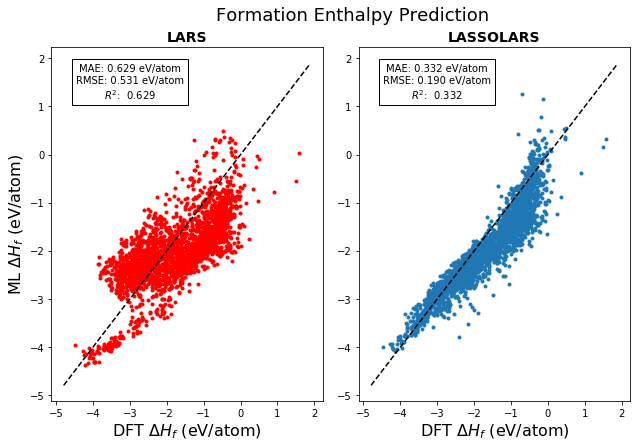

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Formation Enthalpy Prediction', fontsize=18, x=0.55, y=1.03)
ax1.set_title("LARS", fontsize=14, weight='bold')
ax2.set_title("LASSOLARS", fontsize=14, weight='bold')

ax1.scatter(DFT_delta_e, ML_delta_e_lars, marker='.', color='r')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')

ax2.scatter(DFT_delta_e, ML_delta_e_lassolars, marker='.')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')

ax1.set_xlabel('DFT $\Delta H_f$ (eV/atom)', fontsize=16)
ax1.set_ylabel('ML $\Delta H_f$ (eV/atom)', fontsize=16)
ax2.set_xlabel('DFT $\Delta H_f$ (eV/atom)', fontsize=16)
ax1.text(-3., 1.5, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_lars, rmse_lars, r2_lars),
         horizontalalignment='center',
         verticalalignment='center',
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.text(-3, 1.5, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_lassolars, rmse_lassolars, r2_lassolars),
         horizontalalignment='center',
         verticalalignment='center',
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

fig.set_size_inches(9, 6)
fig.tight_layout()

***Large mean absolute error as compared to ~80 meV/atom in paper.***

**FINDING**: When using LassoLars model, there are always one or two extreme outliers , but the fit is much better. But when using Lars model with less than 10 descriptors, there will be no outlier, but fit is worse. 

# Using RandomForestRegressor model 

We're trying to study if the bad prediction using Least Angle Regression linear model is due to the lack of nonlinear features.

In [28]:
data = shuffle(data)
data.fillna(value=0.0, inplace=True)

In [29]:
x = data.drop(['oxidation_states', 'total_energy', 'delta_e', 'composition', 'composition_obj'], 1)
y = data['total_energy']

Dividing datasets into training, validation and testing sets

In [30]:
n = data.shape[0]
x_train, x_val, x_test = x[:int(n*0.7)], x[int(n*0.7):int(n*0.85)], x[int(n*0.85):]
y_train, y_val, y_test = y[:int(n*0.7)], y[int(n*0.7):int(n*0.85)], y[int(n*0.85):]

Using GridSearchCV to find the optimal number of features. 

In [31]:
model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                     param_grid=dict(max_features=range(10, data.shape[1], 50)),
                     scoring='neg_mean_squared_error', 
                     cv=kfold)

In [32]:
%%time
model.fit(x_train, y_train)

CPU times: user 1h 2min 52s, sys: 21.4 s, total: 1h 3min 14s
Wall time: 2h 2min 14s


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': range(10, 874, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [33]:
model = model.best_estimator_

Cross validated prediction of training, validation and testing sets.

In [34]:
cv_train = cross_val_predict(model, x_train, y_train, cv=kfold) 
cv_val = cross_val_predict(model, x_val, y_val, cv=kfold)
cv_test = cross_val_predict(model, x_test, y_test, cv=kfold)

Plot the prediction of total energy

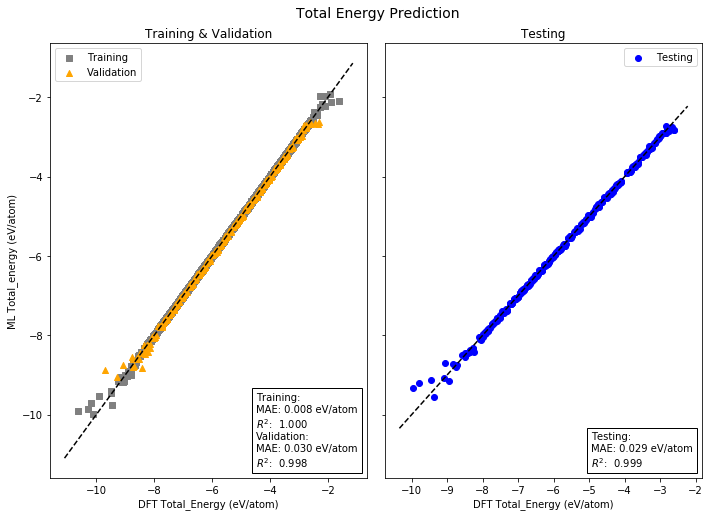

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.suptitle('Total Energy Prediction', fontsize=14, x=0.53, y=1.02)

# Training and Validation plot
mae_train = metrics.mean_absolute_error(y_train, cv_train)
r2_train = metrics.r2_score(y_train, cv_train)
mae_val = metrics.mean_absolute_error(y_val, cv_val)
r2_val = metrics.r2_score(y_val, cv_val)
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax1.scatter(y_train, cv_train, c='grey', marker='s', label='Training')
ax1.scatter(y_val, cv_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')

ax1.legend()

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT Total_Energy (eV/atom)')
ax1.set_ylabel('ML Total_energy (eV/atom)')

# Testing plot
mae_test = metrics.mean_absolute_error(y_test, cv_test)
r2_test = metrics.r2_score(y_test, cv_test)
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.scatter(y_test, cv_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')

ax2.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT Total_Energy (eV/atom)')

fig.set_size_inches(10, 7)
fig.subplots_adjust(hspace=0)
fig.tight_layout()

### Prediction of formation enthalpy

In [36]:
ML_delta_e = pd.Series(index=np.arange(data.shape[0]))

In [37]:
ML_total_energy = model.predict(unshuffled_x)

Importing fitted elemental phase reference energies, $\mu^{FERE}$ from `matminer.utils.data_files.deml_elementdata`

In [38]:
from matminer.utils.data_files.deml_elementdata import mus_fere

Using total energy value to compute formation energy according to the equation 
$$\Delta H_f = E_{tot} - \Sigma_i c_i \mu_i^{FERE}$$

In [39]:
for i in range(data.shape[0]):
    fere = (float(data['composition_obj'][i][str(j)])/data['composition_obj'][i].num_atoms*mus_fere[str(j)] for j in (data['composition_obj'][i]))
    fere = sum(fere)
    ML_delta_e[i] = ML_total_energy[i] - fere

Partitioning both ML and DFT formation enthalpy data into training, validation and testing sets.

In [40]:
DFT_delta_e = unshuffled_delta_e

Plot the prediction of formation enthalpy

In [41]:
mae = metrics.mean_absolute_error(ML_delta_e, DFT_delta_e)
rmse = metrics.mean_squared_error(ML_delta_e, DFT_delta_e)
r2 = metrics.mean_absolute_error(ML_delta_e, DFT_delta_e)

Text(-3.5,1.3,'MAE: 0.278 eV/atom\nRMSE: 0.163 eV/atom\n$R^2$:  0.278')

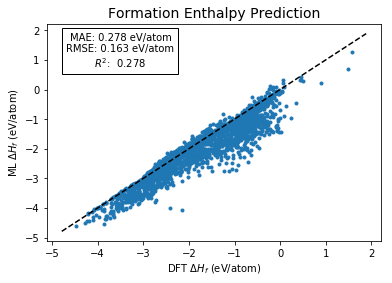

In [64]:
plt.scatter(DFT_delta_e, ML_delta_e, marker='.')
plt.plot(plt.xlim(), plt.xlim(), 'k--')

plt.title('Formation Enthalpy Prediction', fontsize=14)
plt.xlabel('DFT $\Delta H_f$ (eV/atom)')
plt.ylabel('ML $\Delta H_f$ (eV/atom)')
plt.text(-3.5, 1.3, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae, rmse, r2),
         horizontalalignment='center',
         verticalalignment='center',
         bbox={'facecolor': 'w', 'edgecolor': 'k'})

*Finding*: Direct prediction of formation enthalpy is much better. There is a mean absolute error of ~170 meV/atom. 